In [3]:
import torch
import torch.nn as nn

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from models._model import CBPLTrainer

In [4]:
config = {
    "peak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/Microglia_peak_set_2.bed",
    "nonpeak_regions":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file":"/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw",
    "negative_sampling_ratio":0,
    #"train_size": 0.9,
    "batch_size": 64,
    "filters": 256,
    "n_dil_layers":11,
    "conv1_kernel_size": 15,
    "dilation_kernel_size" : 2,
    "num_tasks": 1,
    "input_seq_len": 6000,
    "out_pred_len": 750,
    "learning_rate": 0.001,
    "dropout_rate" : 0.1,
    "train_chrs" : ["chr1","chr2","chr3","chr4","chr5"],
    "valid_chrs" : ["chr22"],
    "seq_focus_len" : 500,
    "loss" : "weighted_norm_mse",
    "use_attention_pooling" : False
}

In [5]:
trainer =  CBPLTrainer(config,checkpoint_path="./cbpl_microglia/robbmrtf/checkpoints/cbpl-epoch=10-val_loss=0.00.ckpt")

Read in bed file of 151351 regions
Read in bed file of 16900 regions
Loaded 151351 peak regions and 0 non-peak regions
Loading model from checkpoint: ./cbpl_microglia/robbmrtf/checkpoints/cbpl-epoch=10-val_loss=0.00.ckpt


In [11]:
for batch in trainer.valid_dataloader:
    inputs, targets = batch
    break  

In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, average_precision_score
from tqdm import tqdm  # Progress bar

def analyze_errors(model, dataloader, device='cpu'):
    model.to(device)
    all_errors = []
    all_inputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches", leave=False):  # Add tqdm here
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs)
            
            # Ensure targets and predictions are 2D
            targets_np = targets.cpu().numpy().reshape(targets.size(0), -1)  # Reshape to [batch_size, num_outputs]
            predictions_np = predictions.cpu().numpy().reshape(predictions.size(0), -1)
            
            mse = mean_squared_error(targets_np, predictions_np, multioutput='raw_values')

            all_errors.append(np.mean(mse))  # Average MSE over the batch
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets_np)
            all_predictions.append(predictions_np)

    all_errors = np.array(all_errors)
    all_inputs = np.concatenate(all_inputs)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    # Sort samples by error
    sorted_indices = np.argsort(all_errors)[::-1]  # Descending order

    return sorted_indices, all_errors, all_inputs, all_targets, all_predictions



In [7]:

validation_dataloader = DataLoader(trainer.valid_dataloader, batch_size=32, shuffle=False)
sorted_indices, errors, inputs, targets, predictions = analyze_errors(trainer.model, trainer.valid_dataloader)




In [8]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def analyze_errors(model, dataloader, loss_functions, device='cpu'):
    model.to(device)
    all_losses = {name: [] for name in loss_functions.keys()}
    all_inputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Processing batches", leave=False):
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = model(inputs)
            
            for name, loss_fn in loss_functions.items():
                loss = loss_fn(predictions, targets)
                all_losses[name].append(loss.item())

            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())

    # Convert lists to numpy arrays
    for name in all_losses.keys():
        all_losses[name] = np.array(all_losses[name])
    all_inputs = np.concatenate(all_inputs)
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)

    # Calculate average loss for each loss function
    avg_losses = {name: np.mean(losses) for name, losses in all_losses.items()}

    # Sort samples by the first loss function (you can change this if needed)
    first_loss_name = list(all_losses.keys())[0]
    sorted_indices = np.argsort(all_losses[first_loss_name])[::-1]  # Descending order

    return sorted_indices, all_losses, avg_losses, all_inputs, all_targets, all_predictions

# Usage
validation_dataloader = DataLoader(trainer.valid_dataloader, batch_size=32, shuffle=False)
sorted_indices, losses, avg_losses, inputs, targets, predictions = analyze_errors(model, validation_dataloader, model.eval_metric) 

NameError: name 'model' is not defined

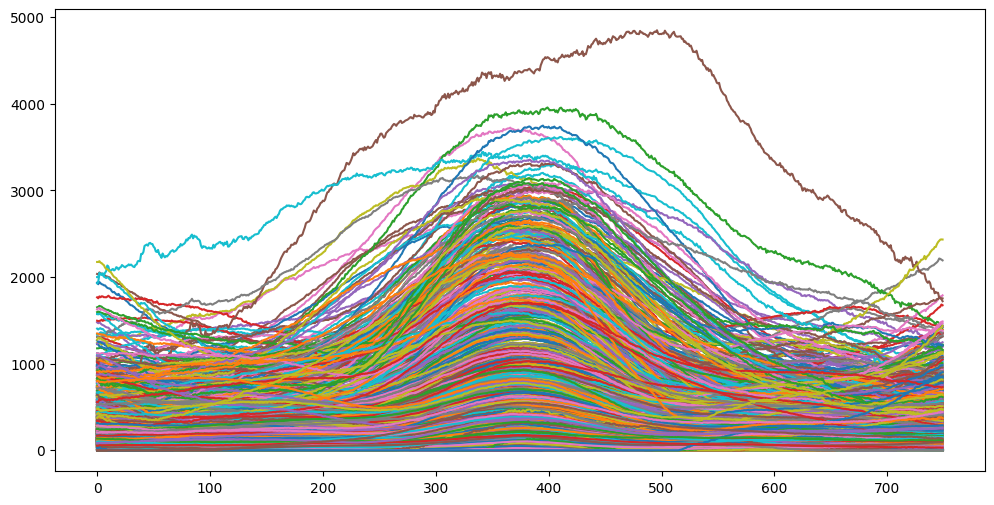

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
for i in range(predictions.shape[0]):
    plt.plot(predictions[i], label=f'Line {i+1}')  # Convert tensor row to numpy for plotting
#plt.legend(loc="upper right", fontsize="small", ncol=2)  # Show legend for all lines
plt.show()

In [22]:
true_peak.shape

(1500,)

In [10]:
N = 10  # Number of worst predictions to analyze
for i in range(N):
    idx = sorted_indices[i]
    true_peak = targets[idx]
    pred_peak = predictions[idx]
    
    # Calculate useful metrics
    true_peak_width = np.sum(true_peak > 0)
    pred_peak_width = np.sum(pred_peak > 0)
    overlap = np.sum((true_peak > 0) & (pred_peak > 0))
    jaccard_index = overlap / np.sum((true_peak > 0) | (pred_peak > 0)) if np.sum((true_peak > 0) | (pred_peak > 0)) > 0 else 0
    
    print(f"Sample {idx}:")
    print(f"  Error (MSE): {errors[idx]}")
    print(f"  True peak width: {true_peak_width}")
    print(f"  Predicted peak width: {pred_peak_width}")
    print(f"  Overlap: {overlap}")
    print(f"  Jaccard index: {jaccard_index:.3f}")
    print(f"  True peak intensity: mean={true_peak.mean():.3f}, max={true_peak.max():.3f}")
    print(f"  Predicted peak intensity: mean={pred_peak.mean():.3f}, max={pred_peak.max():.3f}")
    print()


Sample 1:
  Error (MSE): 139093.546875
  True peak width: 750
  Predicted peak width: 750
  Overlap: 750
  Jaccard index: 1.000
  True peak intensity: mean=162.833, max=486.000
  Predicted peak intensity: mean=314.181, max=684.510

Sample 2:
  Error (MSE): 136587.625
  True peak width: 750
  Predicted peak width: 750
  Overlap: 750
  Jaccard index: 1.000
  True peak intensity: mean=32.951, max=55.000
  Predicted peak intensity: mean=97.006, max=179.193

Sample 32:
  Error (MSE): 134848.25
  True peak width: 750
  Predicted peak width: 750
  Overlap: 750
  Jaccard index: 1.000
  True peak intensity: mean=195.213, max=527.000
  Predicted peak intensity: mean=154.887, max=280.139

Sample 7:
  Error (MSE): 127830.7421875
  True peak width: 750
  Predicted peak width: 750
  Overlap: 750
  Jaccard index: 1.000
  True peak intensity: mean=575.392, max=923.000
  Predicted peak intensity: mean=260.290, max=434.744

Sample 28:
  Error (MSE): 122303.25
  True peak width: 750
  Predicted peak widt

In [11]:
import matplotlib.pyplot as plt

def plot_worst_predictions(targets, predictions, n_samples=10):
    fig, axes = plt.subplots(n_samples, 1, figsize=(10, 4*n_samples))
    for i, ax in enumerate(axes):
        idx = sorted_indices[i]
        ax.plot(targets[idx], label='True Peaks')
        ax.plot(predictions[idx], label='Predicted Peaks')
        ax.set_title(f'Sample {idx} (Error: {errors[idx]:.3f})')
        ax.legend()
    plt.tight_layout()
    plt.show()

def plot_best_predictions(targets, predictions, errors, sorted_indices, n_samples=10):
    fig, axes = plt.subplots(n_samples, 1, figsize=(10, 4*n_samples))
    
    for i, ax in enumerate(axes):
        # Pick the indices with the smallest errors (from the sorted_indices array)
        idx = sorted_indices[-(i+1)]  # Start from the end (smallest error)
        
        ax.plot(targets[idx], label='True Peaks')
        ax.plot(predictions[idx], label='Predicted Peaks')
        ax.set_title(f'Sample {idx} (Error: {errors[idx]:.3f})')
        ax.legend()

    plt.tight_layout()
    plt.show()


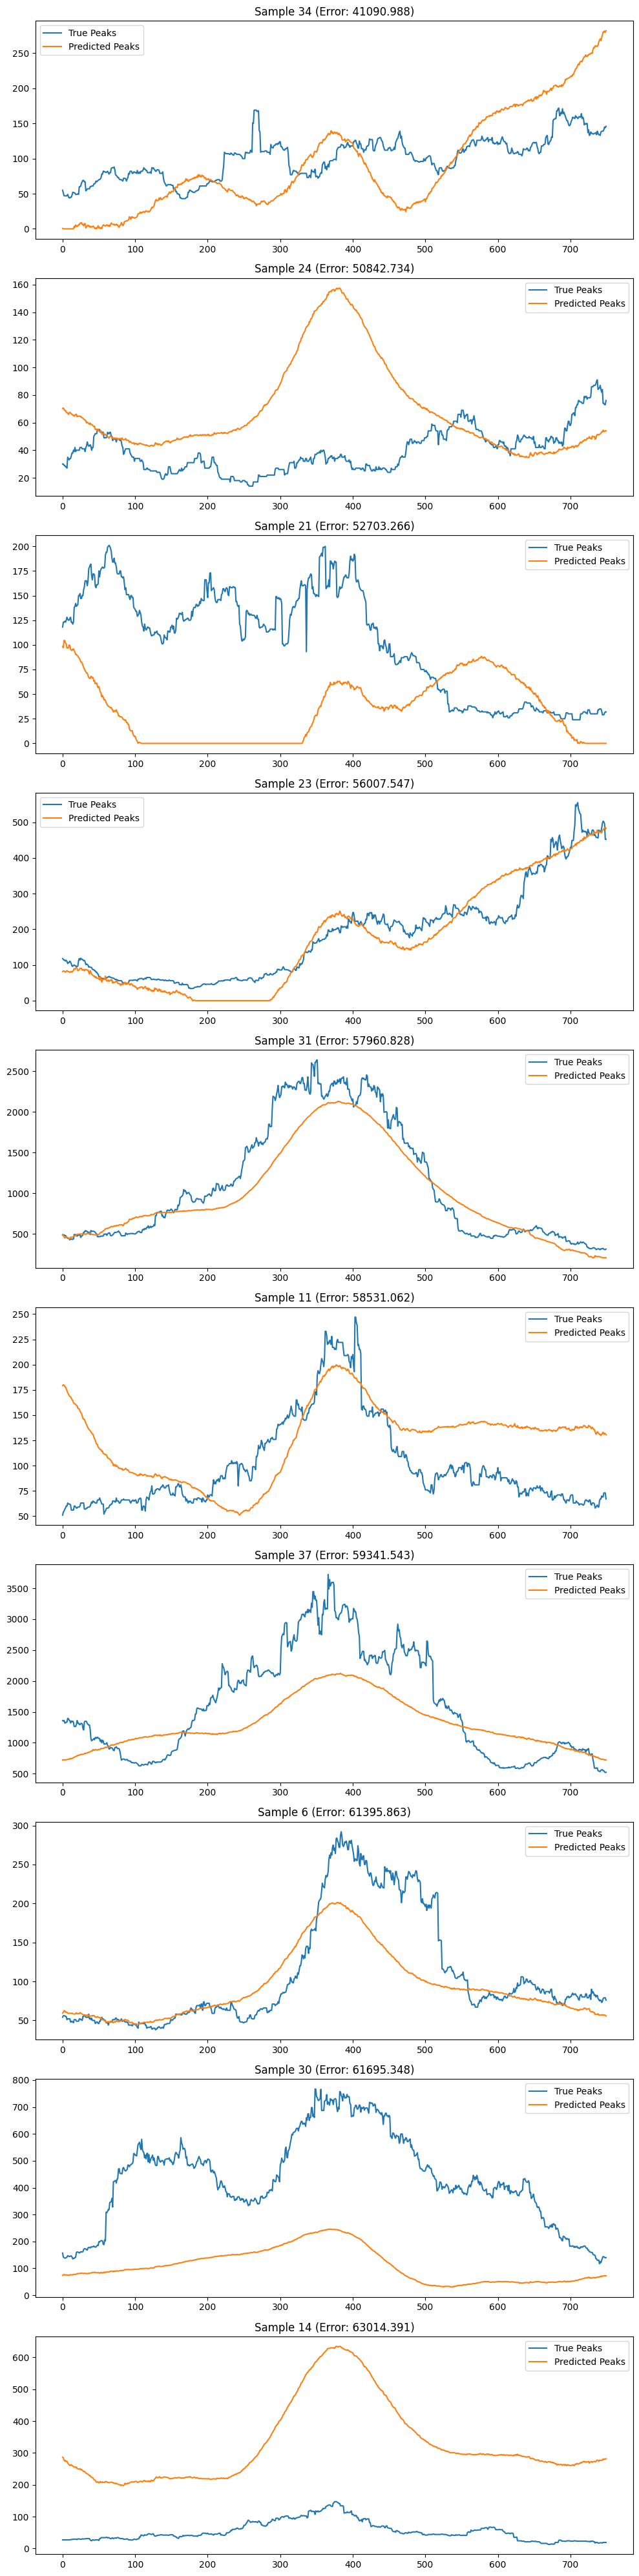

In [12]:
plot_best_predictions(targets, predictions, errors, sorted_indices)


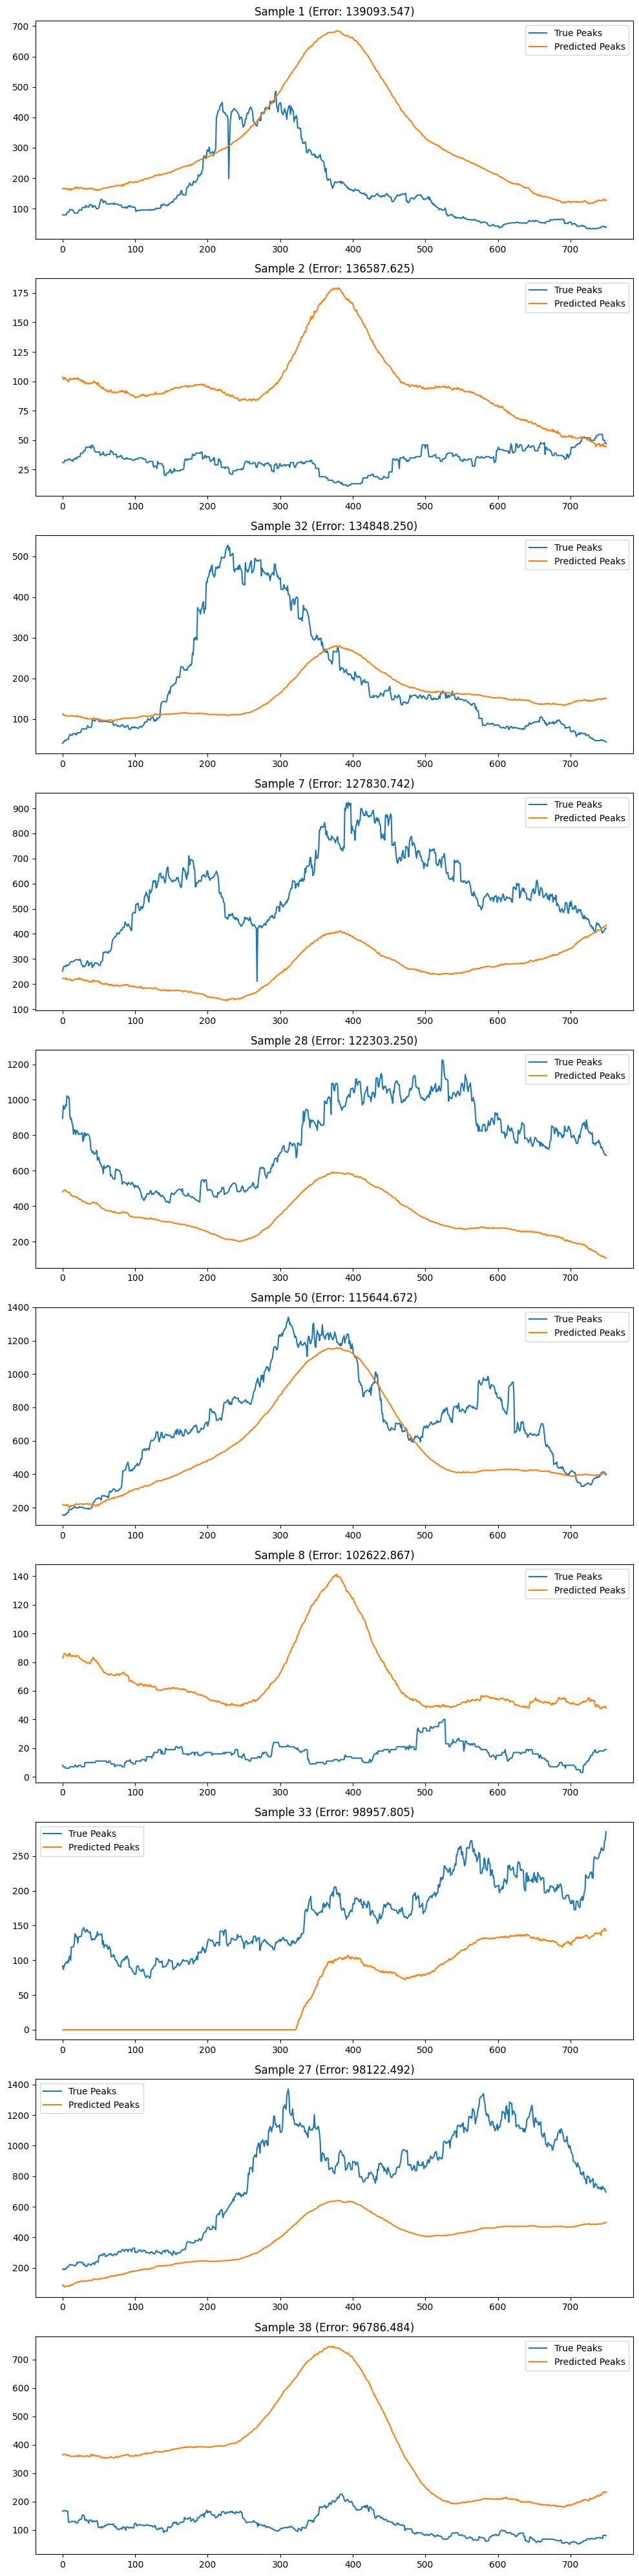

In [13]:
plot_worst_predictions(targets, predictions)
